In [1]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from xgboost import XGBRegressor
from sklearn.model_selection import StratifiedKFold 
from sklearn.base import clone
from sklearn.metrics import mean_squared_log_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

warnings.filterwarnings('ignore')
seed = 27

# Loading Data

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv', index_col='id')

In [3]:
train.describe()

,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
count,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000
mean,0.517098,0.401679,0.135464,0.789035,0.340778,0.169422,0.225898,9.696794
std,0.118217,0.098026,0.038008,0.457671,0.204428,0.100909,0.130203,3.176221
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.445000,0.345000,0.110000,0.419000,0.177500,0.086500,0.120000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.330000,0.166000,0.225000,9.000000
75%,0.600000,0.470000,0.160000,1.067500,0.463000,0.232500,0.305000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [4]:
train.head()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
id,,,,,,,,,
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


# Preprocessing

In [5]:
train['Sex'] = train['Sex'].map({'M': 0, 'F': 1, 'I': 2})
test['Sex'] = test['Sex'].map({'M': 0, 'F': 1, 'I': 2})

numerical_features = ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']

In [6]:
X = train.drop(columns='Rings')
y = train['Rings']

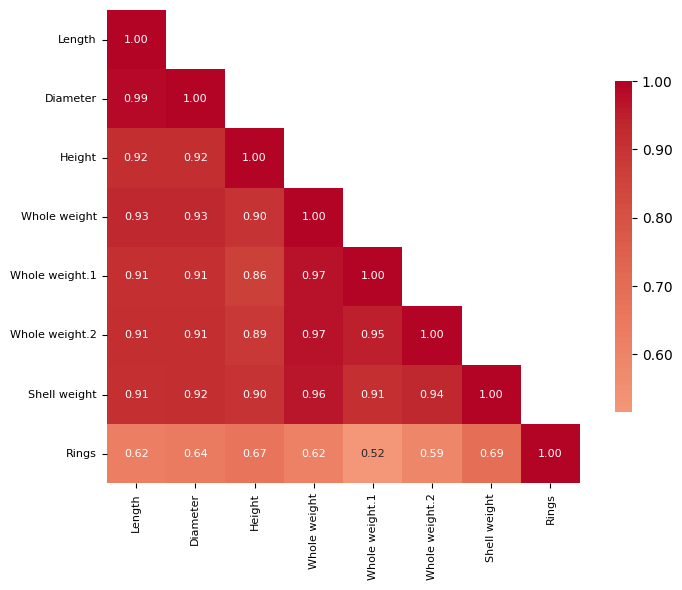

In [7]:
plt.figure(figsize=(8, 6))
corr = train[numerical_features + ['Rings']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
sns.heatmap(
    data=corr,
    annot=True,
    fmt='.2f',
    mask=mask,
    square=True,
    cmap='coolwarm',
    cbar_kws={'shrink': .7, 'format': '%.2f'},   
    annot_kws={'size': 8},
    center=0
)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tight_layout()
plt.show()

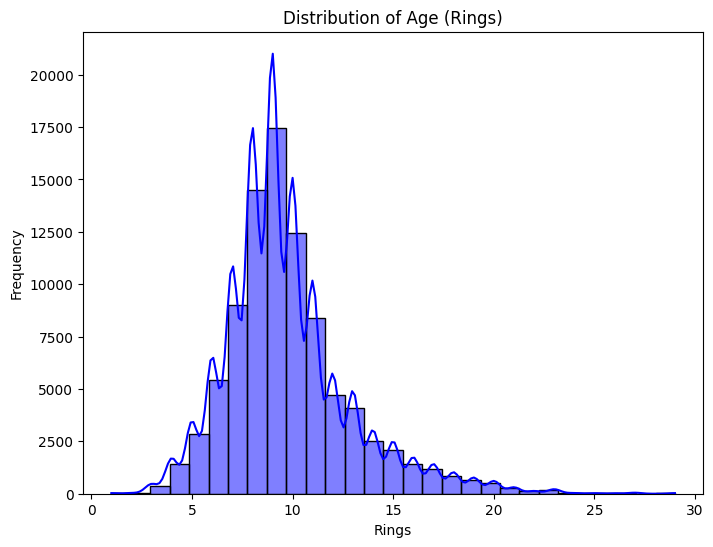

In [8]:
plt.figure(figsize=(8, 6))
sns.histplot(train['Rings'], bins=29, kde=True, color='blue')
plt.title('Distribution of Age (Rings)')
plt.xlabel('Rings')
plt.ylabel('Frequency')
plt.show()

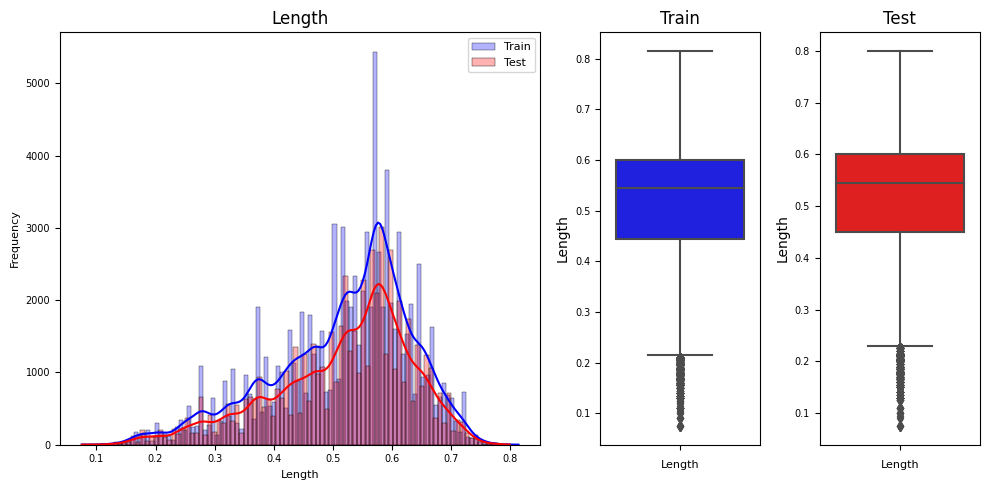

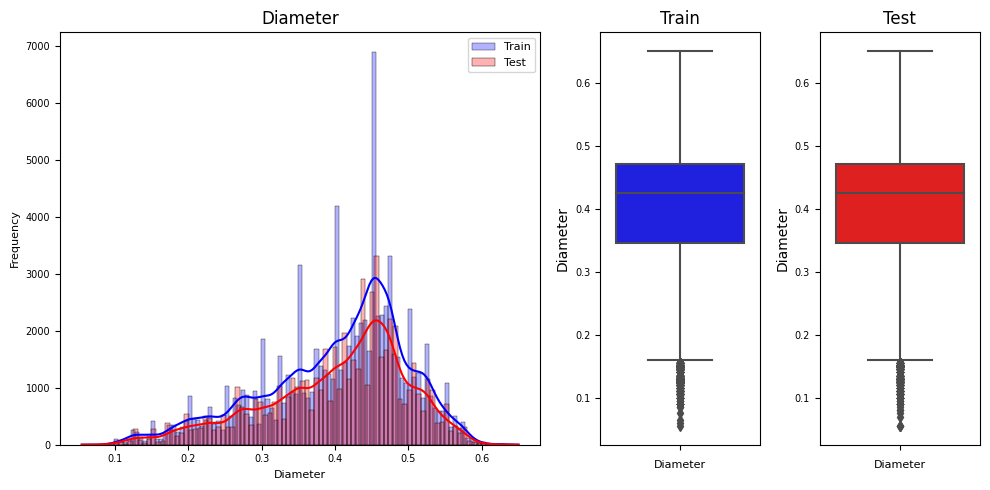

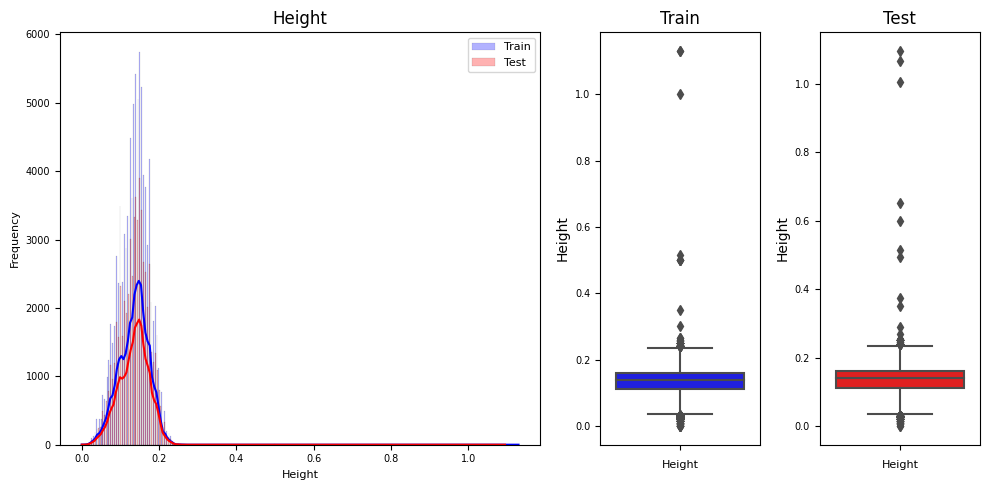

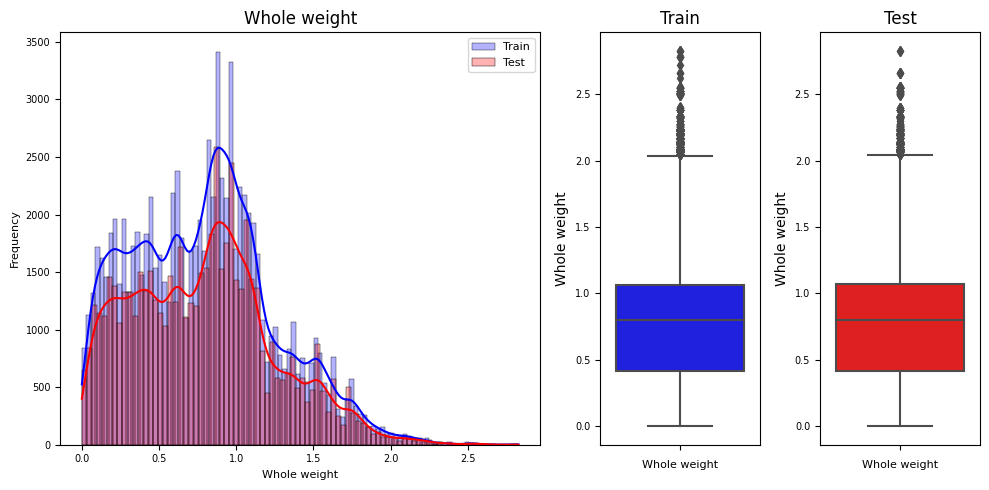

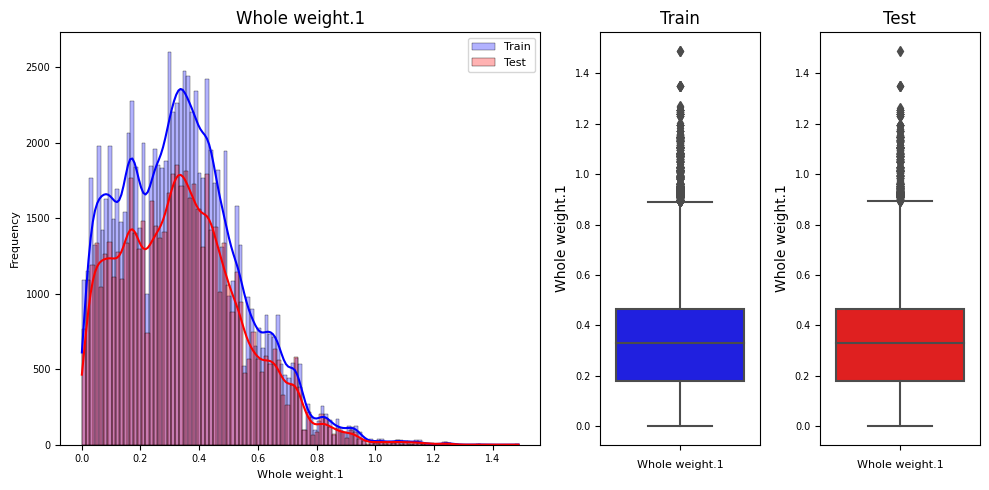

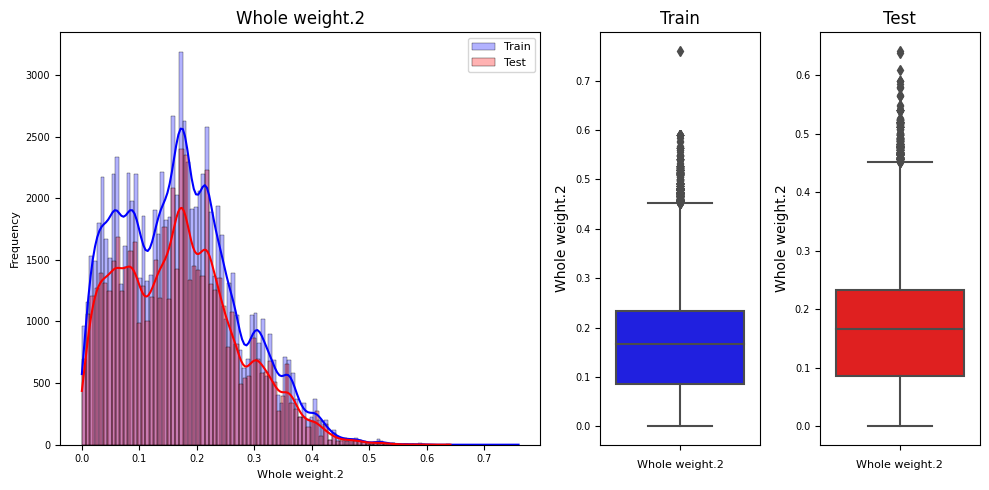

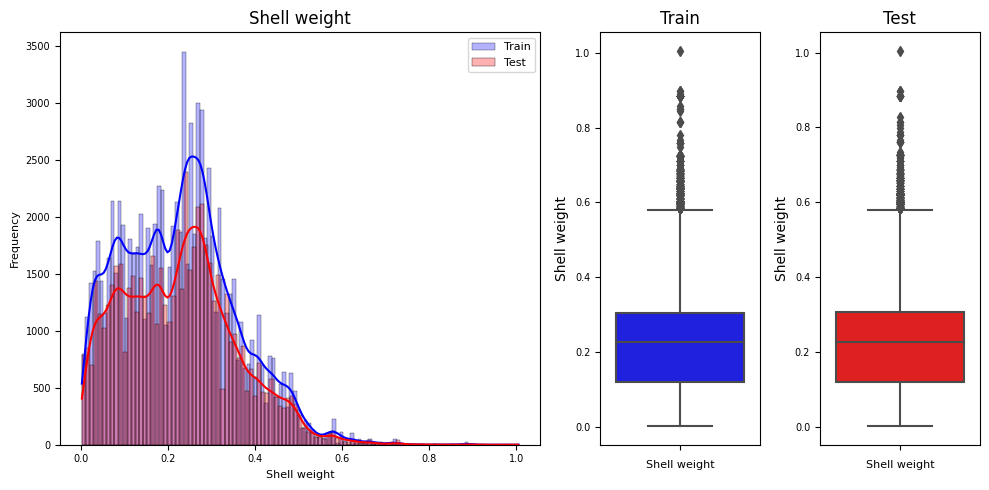

In [9]:
for i, col in enumerate(numerical_features):   
    plt.figure(figsize=(10, 5))
    gs = gridspec.GridSpec(1, 3, width_ratios=[3, 1, 1])
    
    ax1 = plt.subplot(gs[0])
    sns.histplot(train[col], kde=True, color='blue', alpha=0.3, label='Train', ax=ax1)
    sns.histplot(test[col], kde=True, color='red', alpha=0.3, label='Test', ax=ax1)
    ax1.set_title(col)
    ax1.set_xlabel(col, fontsize=8)
    ax1.set_ylabel('Frequency', fontsize=8)
    ax1.legend(fontsize=8)
    ax1.tick_params(axis='both', which='major', labelsize=7)
    
    ax2 = plt.subplot(gs[1])
    sns.boxplot(data=train, y=col, color='blue', orient='h', ax=ax2)
    ax2.set_title('Train')
    ax2.set_xlabel(col, fontsize=8)
    ax2.tick_params(axis='both', which='major', labelsize=7)
    
    ax3 = plt.subplot(gs[2])
    sns.boxplot(data=test, y=col, color='red', orient='h', ax=ax3)
    ax3.set_title('Test')
    ax3.set_xlabel(col, fontsize=8)
    ax3.tick_params(axis='both', which='major', labelsize=7)
    
    plt.tight_layout()
    plt.show()

# Defining CV & Training Function

In [10]:
def train(model, X, y, n_repeats):
    skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
    
    scores = []
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        y_pred = np.zeros_like(y_val, dtype=float)
        
        for i in range(n_repeats):
            m = clone(model)
            if n_repeats > 1:
                m.regressor.set_params(random_state=i)
            m.fit(X_train, y_train)
            y_pred += m.predict(X_val)
            
        y_pred /= n_repeats
        y_pred = y_pred.clip(1, 29)
        
        score = mean_squared_log_error(y_val, y_pred, squared=False)
        scores.append(score)
        
    return np.array(scores).mean()
    
def predict(model, X, y, X_test, n_repeats):
    y_pred = np.zeros(len(X_test), dtype=float)
    for i in range(n_repeats):
        m = clone(model)
        if n_repeats > 1:
            m.regressor.set_params(random_state=i)
        m.fit(X, y)
        y_pred += m.predict(X_test)
    y_pred /= n_repeats
    y_pred = y_pred.clip(1, 29)
    return y_pred

# Training Base Models

In [11]:
models = [
    CatBoostRegressor(random_state=seed, verbose=False),
    LGBMRegressor(random_state=seed, verbose=-1),
    DecisionTreeRegressor(random_state=seed),
    RandomForestRegressor(random_state=seed, n_jobs=-1),
    GradientBoostingRegressor(random_state=seed),
    KNeighborsRegressor(n_jobs=-1),
    XGBRegressor(random_state=seed, n_jobs=-1),
]

In [12]:
model_scores = {}
for estimator in models:
    model = TransformedTargetRegressor(
        regressor=estimator,
        func=np.log1p,
        inverse_func=np.expm1
    )
    
    if estimator.__class__.__name__ == "KNeighborsRegressor":
        n_repeats = 1
    else:
        n_repeats = 5
        
    score = train(model, X, y, n_repeats=n_repeats)
    model_scores[estimator.__class__.__name__] = score
    print(f'{estimator.__class__.__name__}: {score}')

CatBoostRegressor: 0.14860394165150653
LGBMRegressor: 0.14971550046348217
DecisionTreeRegressor: 0.2091914739665313
RandomForestRegressor: 0.1521159502794456
GradientBoostingRegressor: 0.1527494092391393
KNeighborsRegressor: 0.1630746112655388
XGBRegressor: 0.15038651719243415


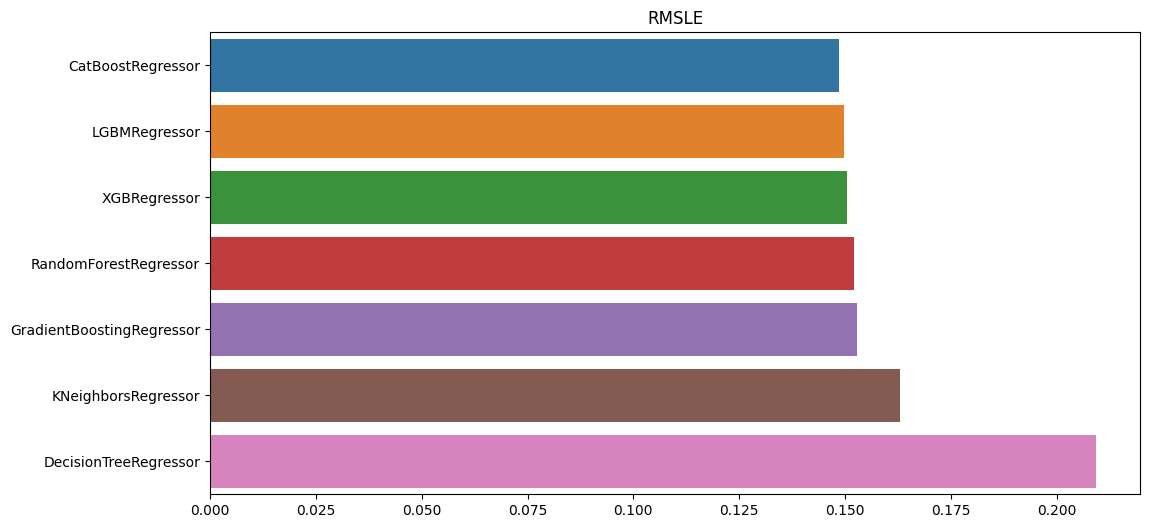

In [13]:
model_scores = dict(sorted(model_scores.items(), key=lambda x: x[1]))

plt.figure(figsize=(12, 6))
sns.barplot(y=list(model_scores.keys()), x=list(model_scores.values()))
plt.title('RMSLE')
plt.show()

# Training the Best Model and Creating a Submission File

In [14]:
best_model = list(model_scores.keys())[0]
model = [model for model in models if model.__class__.__name__ == best_model][0]

model = TransformedTargetRegressor(
    regressor=model,
    func=np.log1p,
    inverse_func=np.expm1
)

predictions = predict(model, X, y, test, n_repeats=5)

In [15]:
submission = pd.DataFrame({'id': test.index, 'Rings': predictions})
submission.to_csv(f'{best_model}.csv', index=False)
submission.head()

,id,Rings
0,90615,9.682932
1,90616,9.681383
2,90617,9.976200
3,90618,10.223813
4,90619,7.530556


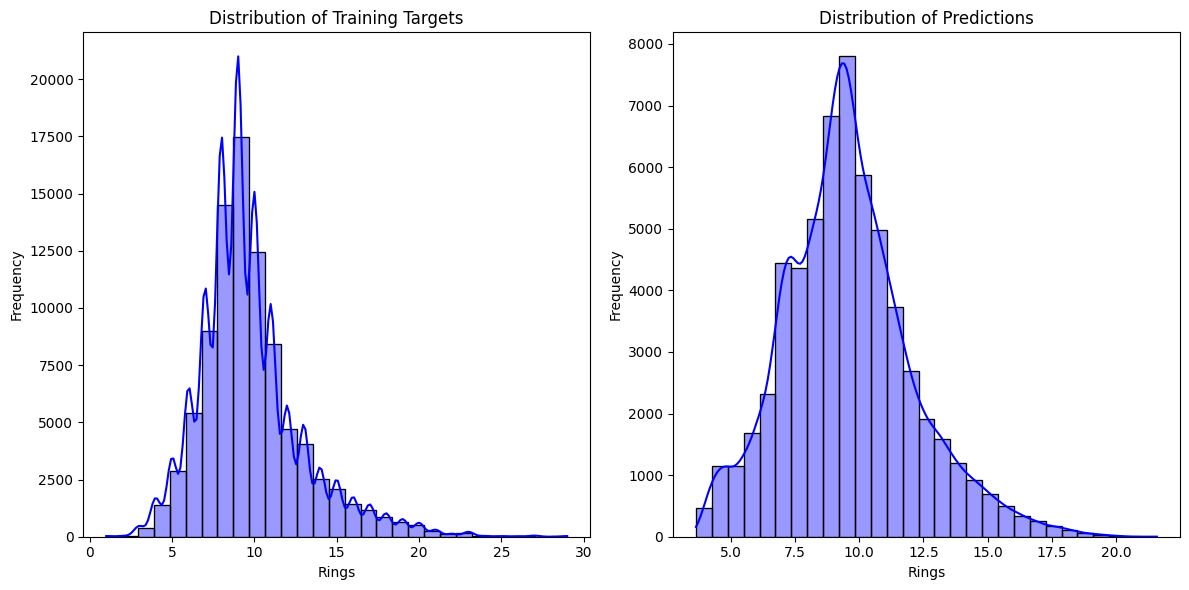

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(y, bins=29, kde=True, color='blue', alpha=0.4, label='Training Targets', ax=axes[0])
axes[0].set_title('Distribution of Training Targets')
axes[0].set_xlabel('Rings')
axes[0].set_ylabel('Frequency')

sns.histplot(predictions, bins=29, kde=True, color='blue', alpha=0.4, label='Predictions', ax=axes[1])
axes[1].set_title('Distribution of Predictions')
axes[1].set_xlabel('Rings')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()